In [1]:
import sys
import os

In [2]:
if 'google.colab' in sys.modules:
    os.system('apt install python3-mpi4py cython3 libxc-dev gpaw-data')
    os.system('pip install --upgrade gpaw pymatgen')

In [3]:
from ase.build import bulk
from ase.atom import Atom
from ase.atoms import Atoms
from gpaw import GPAW, PW
from ase.visualize.plot import plot_atoms
from ase.visualize import view
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
plt.rc('figure', figsize=(18,6))
plt.rc('font', size=20)
from ase.eos import EquationOfState

otras funciones de conveniencia:

In [4]:
def econvergence(E: list[float]):
    return np.abs((E[:-1] - E[-1])/E[-1])

def load_calc(filename, **kwargs):
    if os.path.exists(filename):
        calc = GPAW(filename)
    else:
        calc = GPAW(**kwargs)
    return calc
        

# Generamos la estructura

la función [ase.build.bulk](https://wiki.fysik.dtu.dk/ase/ase/build/build.html?highlight=build) genera estructuras bulk, los argumentos son la composición química, la estructura cristalina, el parámetro de red y si se quiere una celda convencional o primitiva. El Output es un [objeto atoms](https://wiki.fysik.dtu.dk/ase/ase/atoms.html#ase.Atoms), que permitirá luego manipular sus componentes. Se puede pensar el estos objetos como listas de [objetos Atom](https://wiki.fysik.dtu.dk/ase/ase/atom.html#ase.atom.Atom), de átomos individuales

In [5]:
AuFCC = bulk('Au', 'fcc', a=4.2, cubic=True)

In [6]:
printatoms = [print(at) for at in AuFCC]

Atom('Au', [0.0, 0.0, 0.0], index=0)
Atom('Au', [0.0, 2.1, 2.1], index=1)
Atom('Au', [2.1, 0.0, 2.1], index=2)
Atom('Au', [2.1, 2.1, 0.0], index=3)


In [7]:
AuFCC.positions

array([[0. , 0. , 0. ],
       [0. , 2.1, 2.1],
       [2.1, 0. , 2.1],
       [2.1, 2.1, 0. ]])

Luego con la función plot_atoms podemos visualizarlos, pero la verdad es que no es muy buena, solo para visualizar la estructura rápidamente en el Jupyter Notebook

<AxesSubplot:>

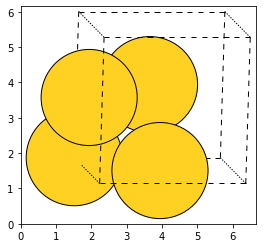

In [8]:
plot_atoms(AuFCC, rotation='10x, 10y')

o bien, para poder rotarlo a mano (pero no se si anda en google colab)


Una forma más presentable de visualizar las estructuras es usando por ejemplo [VESTA](http://www.jp-minerals.org/vesta/en/download.html) 

# Tareas
1.  convergencia en puntos K y en ondas planas
2. Calcular curva E-V  y ajustar parámetro de red.
3. Generar Superficie
3. Calcular estructura electrónica, i.e. densidad de estados. ¿Qué cambia ? 

# Definimios la calculadora

In [9]:
calc = GPAW(mode=PW(300), xc='PBE', txt='SiBDiamondExample.txt',kpts=[5,5,5])
AuFCC.set_calculator(calc)
AuFCC.get_potential_energy()

-12.251315393335263

# K-point convergence 

con lo siguiente hacemos una carpeta donde se guardan los 

In [10]:
import os

In [11]:
calcsdir='calcs_kpoints'
if not os.path.exists(calcsdir):
    os.makedirs(calcsdir)

In [12]:
structures = [('fcc', AuFCC, 4.2)]

In [13]:
kpoints = [3, 4, 5,7,9,11,13]
Ekpt = {}

In [14]:
for case in structures:
    name, struc, latpar = case
    Ekpt[name] = np.array([])
    for kpt in tqdm(kpoints):
        # Energía cinética de corte 300 eV. Divido celda en grilla de "kpt*kpt*kpt"
        # archivos GPAW y txt a guardar 
        gpawfile =os.path.join(calcsdir, f'{name}_kpts_{kpt}.gpaw')
        logfile = os.path.join(calcsdir, f'{name}_{kpt}.txt')
        # cargo el calculador con la función definida antes
        calc = load_calc(gpawfile, mode=PW(300), txt=logfile, xc='PBE', kpts=[kpt,kpt,kpt])
        struc.set_calculator(calc)
        # Divide la energía potencial por el número de átomos, para normalizar, por si llegara a comparar estructuras con diferente cantidad de átomos.
        Ekpt[name]=np.append(Ekpt[name], struc.get_potential_energy()/struc.get_global_number_of_atoms())
        struc.calc.write(gpawfile)

  0%|          | 0/7 [00:00<?, ?it/s]

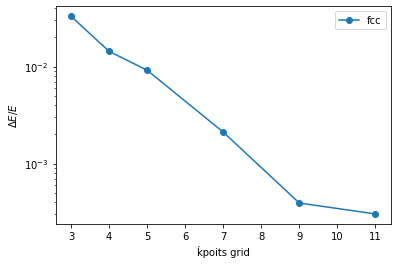

In [15]:
plots = [plt.plot(kpoints[:-1], np.abs((energies[:-1]-energies[-1])/energies[-1]), '-o', label = struc) for struc, energies in Ekpt.items()]
plt.yscale('log')
plt.ylabel('$\Delta E / E$')
plt.xlabel('ḱpoits grid')
plt.legend()

In [16]:
KPT = 7

# cutoff convergence

In [17]:
calcsdir = 'calcs_ecut'
if not os.path.exists(calcsdir):
    os.makedirs(calcsdir)

In [18]:
ecuts = [200, 250, 300, 400, 500,600]
Ecutoff = {}

In [19]:
structures

[('fcc',
  Atoms(symbols='Au4', pbc=True, cell=[4.2, 4.2, 4.2], calculator=GPAW(...)),
  4.2)]

In [20]:
for case in structures:
    name, struc, latpar = case
    Ecutoff[name] = np.array([])
    progress = tqdm(ecuts)
    for ecut in progress:
        filename = os.path.join(calcsdir, f'{name}_{ecut}.gpaw')
        logfilename = os.path.join(calcsdir, f'{name}_{ecut}.txt')
        # Energía cinética de corte "ecut" eV. Divido celda en grilla de "KPT*KPT*KPT".
        calc = load_calc(filename, mode=PW(ecut), txt=logfilename, xc='PBE', kpts=[KPT,KPT,KPT])
        struc.set_calculator(calc)
        # Divide la energía potencial por el número de átomos, para normalizar, por si llegara a comparar estructuras con diferente cantidad de átomos.
        Ecutoff[name]=np.append(Ecutoff[name], struc.get_potential_energy()/struc.get_global_number_of_atoms())
        struc.calc.write(filename)

  0%|          | 0/6 [00:00<?, ?it/s]

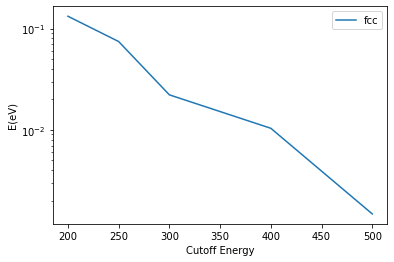

In [21]:
[plt.plot(ecuts[:-1], np.abs((energies[:-1]-energies[-1])/energies[-1]), label = name) for name, energies in Ecutoff.items()]
plt.yscale('log')
plt.ylabel('E(eV)')
plt.xlabel('Cutoff Energy')
plt.legend()

In [22]:
ECUT = 400

# Lattice Parameter

funcion vieja

``` python
def evcurve(element, structure, sizes, calculator):
    print(f'working on {element} in {structure}')
    structures = []
    E = []
    V = []
    progress = tqdm(sizes)
    for a in progress:
        calc = GPAW(mode=PW(ECUT), xc='PBE', txt=f'{element}{structure}_{a}.txt',kpts=[KPT,KPT,KPT])
        structures.append(bulk(element, structure, a=a, cubic=True))
        structures[-1].set_calculator(calculator)
        E.append(structures[-1].get_potential_energy())
        V.append(structures[-1].get_volume())
    return {'E': E, 'V': V, 'strucs': structures}

latparams = {'fcc': np.linspace(3.8,4.5,10)}
```

funcion nueva:

In [23]:
import ase, gpaw
def doevcurve(name: str, struc: ase.atoms.Atoms, sizes: np.ndarray, gpaw_kwargs:dict):
    """
    name: str con el nombre de la estructura
    struc: atoms object con la estructura a calcular
    sizes: np.ndarray con los parametros de red para esta estructura
    gpaw_kwargs: opciones para gpaw
    """
    E = []
    V = []
    progress = tqdm(sizes)
    for latpar in progress:
        gpawfile = os.path.join(latparcalcs, f'{name}_latpar_{latpar:.2f}.gpaw')
        logfile = os.path.join(latparcalcs, f'{name}_latpar_{latpar:.2f}.txt')
        gpaw_kwargs.update({'txt': logfile})
        calc = load_calc(gpawfile, **gpaw_kwargs)
        struc.set_cell(latpar*np.eye(3), scale_atoms=True) # ojo, esto vale solo para cubicas !
        struc.set_calculator(calc)
        V.append(struc.get_volume())
        E.append(struc.get_potential_energy())
        struc.calc.write(gpawfile)
    return {'V': V, 'E': E}
        
        


opciones gpaw:

In [24]:
GPAW_KWARGS = dict(mode=PW(ECUT), xc='PBE', kpts=[KPT,KPT,KPT])

donde guardar resultados:

In [25]:
latparcalcs = 'calcs_latpar'

if not os.path.exists(latparcalcs):
    os.makedirs(latparcalcs)

In [26]:
evcurves={}

In [27]:
structures

[('fcc',
  Atoms(symbols='Au4', pbc=True, cell=[4.2, 4.2, 4.2], calculator=GPAW(...)),
  4.2)]

In [28]:
for case in structures:
    name, struc, guess = case
    print(guess)
    latparams = np.linspace(guess*0.95, guess*1.05, 10)
    evcurves[name] = doevcurve(name,struc, latparams, GPAW_KWARGS)

4.2


  0%|          | 0/10 [00:00<?, ?it/s]

In [29]:
guess

4.2

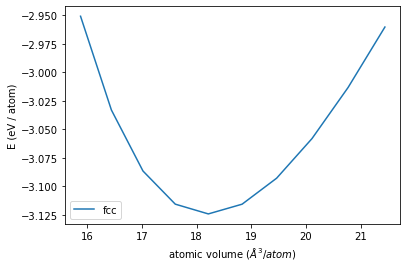

In [30]:
for (name, evcurve), case in zip(evcurves.items(), structures):
    structure = case[1]
    natoms = structure.get_global_number_of_atoms()
    plt.plot(np.array(evcurve['V'])/natoms,np.array(evcurve['E'])/natoms, label=name)
plt.legend()
xlabel=plt.xlabel('atomic volume ($\AA ^3 / atom $)')
ylabel = plt.ylabel('E (eV / atom)')

# Ecuación de Estado 

In [31]:
eos = EquationOfState(evcurves['fcc']['V'],evcurves['fcc']['E'],eos='birchmurnaghan')

In [32]:
eos.fit()

(72.80222747861319, -12.497324250717606, 0.8445097792424887)

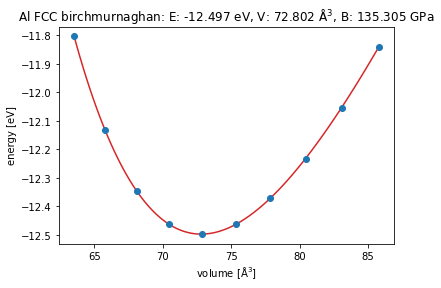

In [33]:
ax = eos.plot()
title = ax.get_title()
newtitle = ax.set_title('Al FCC ' + title)

In [34]:
eqa = eos.v0**(1/3)

In [35]:
eqa

4.175561543335678

# Generar una superficie de n capas 

Para modelar una superficie para cálculos DFT es necesario tomar un modelo de condiciones periódicas de contorno. Para modelar el clivaje del material, se introduce un vacío en la celda unidad que, para que se cumplan las condiciones de contorno periódicas, debe ser suficientemente grande. ASE nos brinda (herramientas)[https://wiki.fysik.dtu.dk/ase/ase/build/surface.html]  para construir superficies simples o bien en base a un objeto Atoms bulk ya presente, [ase.build.surface](https://wiki.fysik.dtu.dk/ase/ase/build/surface.html?highlight=surface#ase.build.surface)

In [36]:
from ase.build import surface, fcc100, fcc110, fcc111, make_supercell

In [37]:
AuMonoLayer = fcc100('Au',[1,1,1], a=eqa, vacuum=10)

<AxesSubplot:>

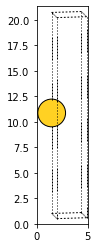

In [38]:
plot_atoms(AuMonoLayer, rotation='90x, 10y, 10x')

con lo cual construimos una n-capa de oro fcc con índices de miller 100. para poder visualizar esta bicapa con mas repeticiones, podemos repetir mas veces la supercelda que acabamos de crear,

In [39]:
AuMonoLayer_2x2 = make_supercell(AuMonoLayer, [[2,0,0],[0,2,0],[0,0,1]])
AuMonoLayer_3x3 = make_supercell(AuMonoLayer, [[3,0,0],[0,3,0],[0,0,1]])
AuMonoLayer_4x4 = make_supercell(AuMonoLayer, [[4,0,0],[0,4,0],[0,0,1]])

<AxesSubplot:>

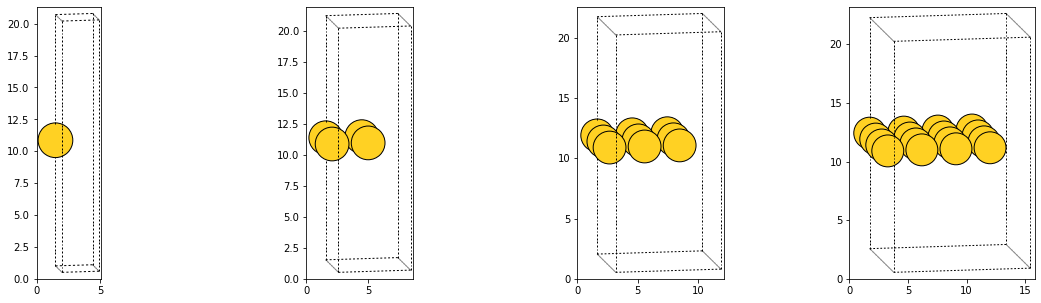

In [40]:
fig, ax = plt.subplots(1,4,figsize=(20,5))
plot_atoms(AuMonoLayer, rotation='90x, 10y, 10x', ax=ax[0])
plot_atoms(AuMonoLayer_2x2, rotation='90x, 10y, 10x', ax=ax[1])
plot_atoms(AuMonoLayer_3x3, rotation='90x, 10y, 10x', ax=ax[2])
plot_atoms(AuMonoLayer_4x4, rotation='90x, 10y, 10x', ax=ax[3])

# Calculos de superficies 

Para calcular superficies, se usa el objeto Atms con vacío , cambiand los KPOINTS a [KPT/n, KPT/n, 1] donde n es el numero de repeticiones en la supercelda

In [41]:
ECUT

400

In [42]:
KPT

7

y aca va para guardar tambien las monocapas:

In [43]:
layers_dir = 'layers_calcs'

In [44]:
if not os.path.exists(layers_dir):
    os.makedirs(layers_dir)

# calc the monolayer: 

In [45]:
n = 1

In [46]:
monolayerfile = os.path.join(layers_dir, f'layer_{n}.gpaw')

In [47]:
monolayerlog = os.path.join(layers_dir, f'layer_{n}.txt')

In [48]:
GPAW_KWARGS = dict(mode=PW(ECUT), txt='AuMonolayer.txt', xc='PBE', kpts=[KPT, KPT, 1])

In [49]:
calc = load_calc(monolayerfile, **GPAW_KWARGS)

In [50]:
AuMonoLayer.set_calculator(calc)

In [51]:
AuMonoLayer.get_potential_energy()

-2.27315904994927

guardar el calculo:

In [52]:
AuMonoLayer.calc.write(monolayerfile)

# Densidad de Estados 

In [53]:
AuFCC = bulk('Au', 'fcc', a=eqa)

In [54]:
bulk_dos_file = os.path.join(layers_dir, f'bulk_{n}_dos.gpaw')
bulk_dos_log = os.path.join(layers_dir, f'bulk_{n}_dos.txt')

In [55]:
GPAW_KWARGS_BULK=dict(mode=PW(ECUT), xc='PBE', kpts=[15,15,15], txt=bulk_dos_log)

In [56]:
calc = load_calc(bulk_dos_file, **GPAW_KWARGS_BULK)
AuFCC.set_calculator(calc)
AuFCC.get_potential_energy()

-3.129676638651488

In [57]:
monolayer_dos_file = os.path.join(layers_dir, f'layer_{n}_dos.gpaw')
monolayer_dos_log = os.path.join(layers_dir, f'layer_{n}_dos.txt')

In [58]:
GPAW_KWARGS_monolayer=dict(mode=PW(ECUT), xc='PBE', kpts=[15,15,1], txt=monolayer_dos_log)

In [59]:
calcML = load_calc(monolayer_dos_file, **GPAW_KWARGS_monolayer)
AuMonoLayer.set_calculator(calcML)
AuMonoLayer.get_potential_energy()

-2.239717619297238

In [60]:
e,dos = AuFCC.calc.get_dos(npts=500)
e2, dos_ml = AuMonoLayer.calc.get_dos(npts=500)
ef = AuFCC.calc.get_fermi_level()
efml = AuMonoLayer.calc.get_fermi_level()

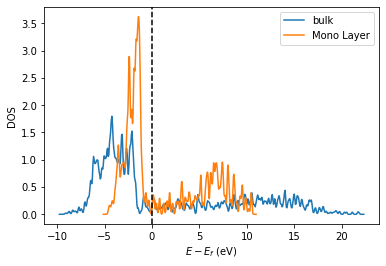

In [61]:
plt.plot(e-ef,dos, label='bulk')
plt.plot(e2-efml,dos_ml, label='Mono Layer')
plt.axvline(color='k', linestyle='--')
plt.xlabel('$E - E_f$ (eV)')
plt.ylabel('DOS')
plt.legend()

# Tareas 

- calcular más capas (1,2,3, etc) 
- ver si es posible recuperar la DOS del bulk
- ¿Agregar impurezas en la superficie ?
- ¿Agregar adsorbatos ?